# Cleaning and Regression
Date: 19.05.2019<br>
Environment: Python 3.6.8 and Anaconda 4.6.7 (64-bit)<br>

In [1]:
from IPython.core.display import HTML
css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## 1. Introduction
>The main purpose of this report is to provide information about the methodology and process to solve this problem.<br>
This report focuses on three parts:
* Fixed the errors in the dirty data. 
* Detect the outliers.
* Imputate the missing values.

## 2.  Logic map

> The procedures implemented in this data cleansing task are as follows:
<img src = "style/0-logicmap.png" height = "600" width = "900" style="float: left;">

## 3.  Import libraries 

In [2904]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from gmplot import gmplot
from scipy.stats import iqr
from sklearn import metrics
from sklearn import neighbors 
from sklearn import metrics
from datetime import datetime
from datetime import timedelta 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression  
from sklearn.linear_model import Ridge,Lasso
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
%matplotlib inline
pd.options.display.float_format = '{:20,.2f}'.format

## 4. EDA Using Missing Valus File
> Here, we use missing value dataset to exploration

In [2905]:
miss = pd.read_csv('dataset/missing_value.csv')

In [2906]:
# save the original column names for furture output export
ori_columns_miss = miss.columns

In [2907]:
miss.head(2)

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1610680870,0.00,7,1,-37.86,144.91,-37.81,144.97,"8,610.00",2018-02-14,09:42:43,"2,903.34",10:31:06,6.29
1,ID1588211620,0.00,3,8,-37.81,144.97,-37.82,145.05,"6,930.00",2018-07-12,05:38:38,"2,031.60",6:12:29,14.50


In [2908]:
miss.columns = ['id','type','orir','desr','orilat','orilong','deslat','deslong', 'distance_m', 'oridate',
               'oritime', 'traveltime_s', 'destime', 'fare']

In [2909]:
miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 14 columns):
id              95 non-null object
type            75 non-null float64
orir            95 non-null int64
desr            95 non-null int64
orilat          95 non-null float64
orilong         95 non-null float64
deslat          95 non-null float64
deslong         95 non-null float64
distance_m      95 non-null float64
oridate         95 non-null object
oritime         95 non-null object
traveltime_s    95 non-null float64
destime         95 non-null object
fare            77 non-null float64
dtypes: float64(8), int64(2), object(4)
memory usage: 10.5+ KB


In [2910]:
miss.describe()

,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,traveltime_s,fare
count,75.00,95.00,95.00,95.00,95.00,95.00,95.00,95.00,95.00,77.00
mean,0.68,4.89,5.12,-37.84,144.94,-37.86,144.92,"15,939.33","4,207.11",65.28
std,0.72,2.61,2.65,0.08,0.09,0.10,0.11,"16,970.74","4,103.08",167.46
min,0.00,1.00,1.00,-38.11,144.65,-38.11,144.65,80.00,16.68,4.62
25%,0.00,3.00,3.00,-37.83,144.93,-37.86,144.91,"4,956.00","1,282.11",13.51
50%,1.00,6.00,5.00,-37.81,144.97,-37.82,144.96,"9,296.00","2,903.34",21.04
75%,1.00,7.00,7.00,-37.80,144.99,-37.81,144.99,"13,265.00","4,029.84",35.10
max,2.00,9.00,9.00,-37.77,145.05,-37.77,145.05,"51,061.00","13,173.36","1,039.94"


### 4.1 Find out the classification criteria for Uber type

In [2911]:
# All type 0 with ID starts from 1
miss[miss['type']==0].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare
0,ID1610680870,0.00,7,1,-37.86,144.91,-37.81,144.97,"8,610.00",2018-02-14,09:42:43,"2,903.34",10:31:06,6.29
1,ID1588211620,0.00,3,8,-37.81,144.97,-37.82,145.05,"6,930.00",2018-07-12,05:38:38,"2,031.60",6:12:29,14.50


In [2912]:
# All type 1 with ID starts from 3
miss[miss['type']==1].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare
2,ID3904312291,1.00,8,9,-37.81,145.03,-38.11,144.65,"49,777.00",2018-04-15,21:15:24,"12,069.78",0:36:33,64.66
6,ID3863693934,1.00,4,1,-37.81,145.02,-37.80,144.96,"5,801.00",2018-04-22,22:18:29,"1,444.02",22:42:33,22.25


In [2913]:
# All type 2 with ID starts from 5
miss[miss['type']==2].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare
10,ID5914236930,2.00,3,1,-37.81,144.98,-37.81,144.96,"2,597.00",2018-05-16,20:58:32,649.26,21:09:21,76.94
15,ID5594425669,2.00,4,1,-37.81,145.00,-37.80,144.96,"3,901.00",2018-05-03,16:32:44,990.72,16:49:14,104.26


### 4.2 Find out the relationship between time, distance and fare

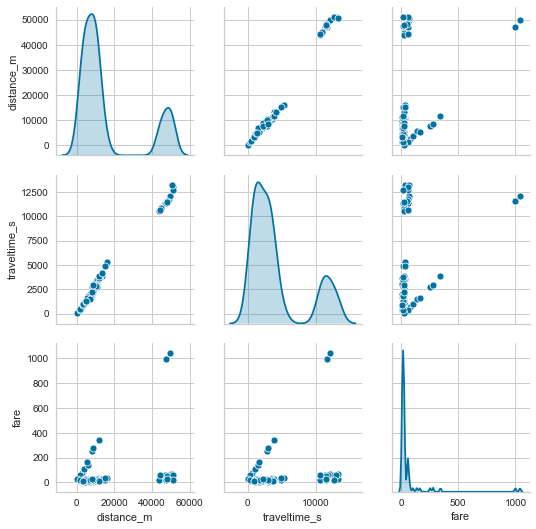

In [2914]:
# from the graph below, we can see there are three different trend
ms_price_vis = miss.copy()[['distance_m','traveltime_s','fare']]
sns.pairplot(ms_price_vis,diag_kind = 'kde')

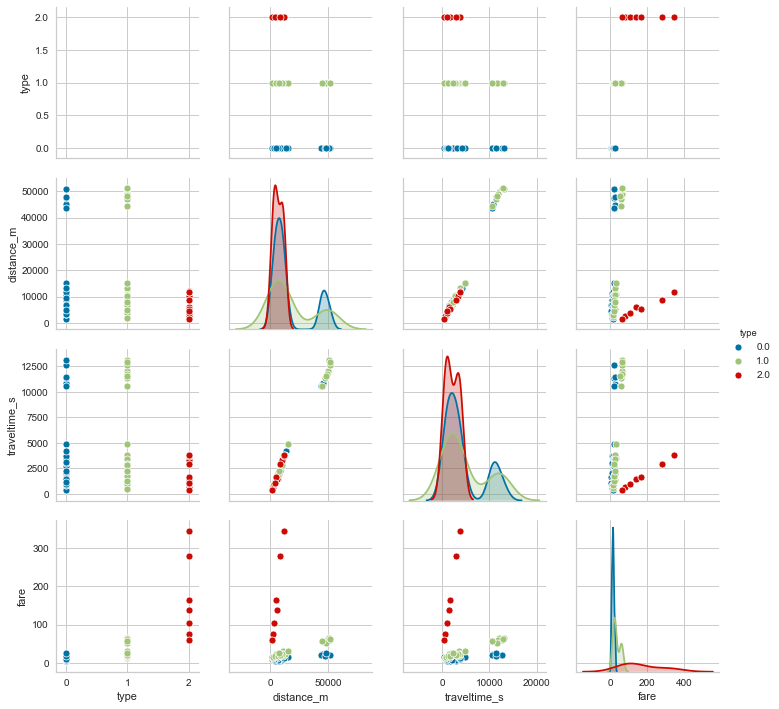

In [2915]:
# we plot by type and fit the three trend
ms_price_vis1 = miss.copy()[['type','distance_m','traveltime_s','fare']]
sns.pairplot(ms_price_vis1,hue = 'type',diag_kind = 'kde')

### 4.3 Extract the Coordinates to see how the region classified

In [2916]:
miss_ori = miss.copy()[['orir','orilat','orilong']].rename(columns={'orir': 'r', 'orilat': 'lat','orilong':'long'})

In [2917]:
miss_des = miss.copy()[['desr','deslat','deslong']].rename(columns={'desr': 'r', 'deslat': 'lat','deslong':'long'})

In [2918]:
outlier_region = pd.read_csv('dataset/30086434_outliers.csv')

In [2919]:
outlier_region.columns = ['index','id','type','orir','desr','orilat','orilong','deslat','deslong', 'distance_m', 'oridate',
       'oritime', 'traveltime_s', 'destime', 'fare']

In [2920]:
out_ori = outlier_region.copy()[['orir','orilat','orilong']].rename(columns={'orir': 'r', 'orilat': 'lat','orilong':'long'})

In [2921]:
out_des = outlier_region.copy()[['desr','deslat','deslong']].rename(columns={'desr': 'r', 'deslat': 'lat','deslong':'long'})

In [2922]:
miss_out_region_eda = pd.concat([miss_ori,miss_des,out_ori,out_des])

In [2923]:
#miss_out_region_eda['source']= 'clean'
#miss_out_region_eda['id']='Clean'

In [2924]:
miss_out_region_eda.head()

,r,lat,long
0,7,-37.86,144.91
1,3,-37.81,144.97
2,8,-37.81,145.03
3,7,-37.86,144.91
4,1,-37.81,144.97


In [2925]:
# save to csv file for visualization
miss_out_region_eda.to_csv('miss_out_region_eda.csv')
# region 9 is hidden for display reason

<img src = "style/1-regionmap.png" height = "500" width = "700" style="float: left;">

## 5. Clean the dirty data

In [3007]:
dirty = pd.read_csv('dataset/dirty_data.csv',float_precision = 'high')

In [3008]:
ori_columns_dirty = dirty.columns

In [3009]:
dirty1 = dirty.copy()

In [3010]:
dirty1.columns = ['id', 'type', 'orir', 'desr','orilat', 'orilong', 'deslat','deslong', 
                  'distance_m', 'oridate','oritime', 'traveltime_s', 'destime', 'fare']

In [3011]:
dirty1.describe()
# unnormal orilat,deslat std

,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,traveltime_s,fare
count,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00
mean,0.74,5.20,4.84,-36.59,144.93,-36.58,144.93,"16,546.24","4,296.05",82.52
std,0.78,2.57,2.57,9.72,0.11,9.73,0.11,"17,017.28","4,087.77",197.90
min,0.00,1.00,1.00,-38.11,144.65,-38.11,144.65,19.00,4.56,4.90
25%,0.00,3.00,3.00,-37.83,144.92,-37.82,144.93,"5,192.50","1,336.42",13.92
50%,1.00,5.00,5.00,-37.81,144.96,-37.82,144.96,"8,772.00","2,730.00",19.92
75%,1.00,7.00,7.00,-37.80,144.99,-37.81,144.99,"15,151.00","4,917.48",38.09
max,3.00,9.00,9.00,37.86,145.05,38.11,145.05,"51,061.00","13,204.98","1,141.83"


In [3012]:
dirty1.describe(include=['O'])

,id,oridate,oritime,destime
count,299,299,299,299
unique,299,159,299,298
top,ID3465813624,2018-04-18,06:41:18,12:10:45
freq,1,5,1,2


In [3013]:
dirty1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 14 columns):
id              299 non-null object
type            299 non-null int64
orir            299 non-null int64
desr            299 non-null int64
orilat          299 non-null float64
orilong         299 non-null float64
deslat          299 non-null float64
deslong         299 non-null float64
distance_m      299 non-null float64
oridate         299 non-null object
oritime         299 non-null object
traveltime_s    299 non-null float64
destime         299 non-null object
fare            299 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 32.8+ KB


### 5.1 Coordinates ( Syntactic Anomalies)

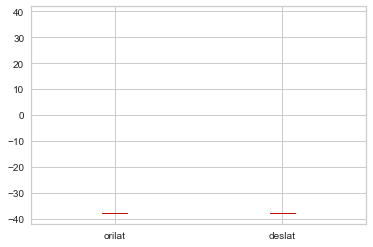

In [3014]:
dirty1.boxplot(column=['orilat','deslat'])

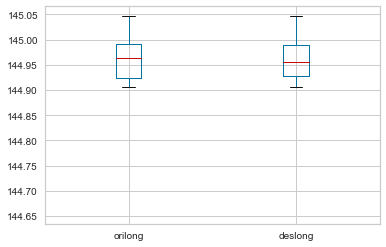

In [3015]:
dirty1.boxplot(column=['orilong','deslong'])

In [3016]:
# Locate the data with syntatic error in Latitude
dirty1[(dirty1.orilat>0)|(dirty1.deslat>0)]

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare
43,ID1215967930,0,6,1,37.77,144.98,-37.81,144.95,"5,803.00",2018-02-19,07:31:32,"1,239.60",7:52:11,5.46
47,ID1393171658,0,7,3,37.86,144.91,-37.82,144.97,"8,061.00",2018-07-06,08:16:19,"2,794.32",9:02:53,5.35
49,ID5890656872,2,4,2,37.80,144.99,-37.82,144.94,"5,817.00",2018-05-20,15:02:27,"1,427.16",15:26:14,150.27
52,ID1731153745,0,8,6,37.81,145.03,-37.79,144.98,"5,793.00",2018-05-18,14:05:44,"1,493.52",14:30:37,9.08
55,ID3333043165,1,3,9,37.82,145.00,-38.11,144.65,"46,937.00",2018-05-14,19:45:55,"11,402.70",22:55:57,59.16
57,ID1195316881,0,2,4,-37.82,144.95,37.81,145.00,"5,168.00",2018-01-28,02:26:34,"1,200.84",2:46:34,18.06
61,ID3175901277,1,7,8,-37.86,144.91,37.81,145.03,"13,986.00",2018-03-11,21:57:58,"4,292.40",23:09:30,39.34
64,ID3418324778,1,4,8,-37.80,145.01,37.82,145.05,"4,609.00",2018-05-22,08:11:16,"1,463.88",8:35:39,10.37
70,ID1407660858,0,1,9,-37.81,144.96,38.11,144.65,"43,650.00",2018-03-07,11:43:36,"10,586.22",14:40:02,22.69
79,ID3285557267,1,4,3,-37.80,144.99,37.81,145.00,"1,830.00",2018-05-18,10:42:23,451.92,10:49:54,5.35


In [3017]:
# Save the ID for different errors
fixed_index = []
err_lat = dirty1[(dirty1.orilat>0)|(dirty1.deslat>0)].index
fixed_index.extend(err_lat)
len(fixed_index)

10

In [3018]:
# Add negative sign if latitude >0 on dirty copy data
dirty1['orilat'] = dirty1['orilat'].map(lambda x: -x if x>0 else x)
dirty1['deslat'] = dirty1['deslat'].map(lambda x: -x if x>0 else x)

In [3019]:
dirty1[dirty1.index.isin(err_lat)]

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare
43,ID1215967930,0,6,1,-37.77,144.98,-37.81,144.95,"5,803.00",2018-02-19,07:31:32,"1,239.60",7:52:11,5.46
47,ID1393171658,0,7,3,-37.86,144.91,-37.82,144.97,"8,061.00",2018-07-06,08:16:19,"2,794.32",9:02:53,5.35
49,ID5890656872,2,4,2,-37.80,144.99,-37.82,144.94,"5,817.00",2018-05-20,15:02:27,"1,427.16",15:26:14,150.27
52,ID1731153745,0,8,6,-37.81,145.03,-37.79,144.98,"5,793.00",2018-05-18,14:05:44,"1,493.52",14:30:37,9.08
55,ID3333043165,1,3,9,-37.82,145.00,-38.11,144.65,"46,937.00",2018-05-14,19:45:55,"11,402.70",22:55:57,59.16
57,ID1195316881,0,2,4,-37.82,144.95,-37.81,145.00,"5,168.00",2018-01-28,02:26:34,"1,200.84",2:46:34,18.06
61,ID3175901277,1,7,8,-37.86,144.91,-37.81,145.03,"13,986.00",2018-03-11,21:57:58,"4,292.40",23:09:30,39.34
64,ID3418324778,1,4,8,-37.80,145.01,-37.82,145.05,"4,609.00",2018-05-22,08:11:16,"1,463.88",8:35:39,10.37
70,ID1407660858,0,1,9,-37.81,144.96,-38.11,144.65,"43,650.00",2018-03-07,11:43:36,"10,586.22",14:40:02,22.69
79,ID3285557267,1,4,3,-37.80,144.99,-37.81,145.00,"1,830.00",2018-05-18,10:42:23,451.92,10:49:54,5.35


### 5.2 Invalid Date ( Syntactic Anomalies)

> Two kinds of Invalid date <br>
    1. Record format inconsistency: month and day reverse
       for this type of error, we can fix it by changing the order.
    2. Day out of range
       for out of range error, we can only imputate it with uncertain.

In [3020]:
def date_validator(d):
    # detect two types of date errors
    try:
        datetime.strptime(d,'%Y-%m-%d')
        return 0
    except ValueError:
        l = d.split('-')
        reverse = f'{l[0]}-{l[2]}-{l[1]}'
        try: 
            datetime.strptime(reverse,'%Y-%m-%d')
            return 1
        except ValueError:
            return 2

In [3021]:
dirty1['date_check'] = dirty1.oridate.apply(date_validator)
dirty1[dirty1.date_check==1].oridate

176    2018-18-04
181    2018-18-02
183    2018-18-04
186    2018-15-06
189    2018-24-05
196    2018-23-03
Name: oridate, dtype: object

In [3022]:
# save the index for error
err_date_mdreverse = dirty1[dirty1.date_check==1].index
fixed_index.extend(err_date_mdreverse)
len(fixed_index)

16

In [3023]:
# fix it by reverse the order
def date_mon_day_reverse(d):
    l = d.split('-')
    reverse = f'{l[0]}-{l[2]}-{l[1]}'
    return reverse

In [3024]:
dirty1.loc[dirty1.date_check==1,'oridate'] = dirty1[dirty1.date_check==1].oridate.apply(date_mon_day_reverse)
dirty1[dirty1.date_check==1].oridate

176    2018-04-18
181    2018-02-18
183    2018-04-18
186    2018-06-15
189    2018-05-24
196    2018-03-23
Name: oridate, dtype: object

In [3025]:
dirty1[dirty1.date_check==2].oridate

203    2018-06-31
205    2018-02-30
209    2018-02-30
211    2018-02-30
216    2018-06-31
220    2018-04-31
222    2018-02-30
223    2018-04-31
225    2018-02-30
226    2018-06-31
Name: oridate, dtype: object

In [3026]:
def outrange_date_chage(d):
    l = d.split('-')
    d_1 = f'{l[0]}-{l[1]}-{int(l[2])-1}'
    d_2 = f'{l[0]}-{l[1]}-{int(l[2])-2}'
    try:
        datetime.strptime(d_1,'%Y-%m-%d')
        return d_1
    except ValueError:
        try: 
            datetime.strptime(d_2,'%Y-%m-%d')
            return d_2
        except ValueError:
            None

In [3027]:
err_date_outrange = dirty1[dirty1.date_check==2].index
fixed_index.extend(err_date_outrange)
len(fixed_index)

26

In [3028]:
dirty1.loc[dirty1.date_check==2,'oridate'] = dirty1[dirty1.date_check==2].oridate.apply(outrange_date_chage)
dirty1[dirty1.date_check==2].oridate

203    2018-06-30
205    2018-02-28
209    2018-02-28
211    2018-02-28
216    2018-06-30
220    2018-04-30
222    2018-02-28
223    2018-04-30
225    2018-02-28
226    2018-06-30
Name: oridate, dtype: object

In [3029]:
# double check the validation of date
def date_double_check(d):
    try:
        datetime.strptime(d,'%Y-%m-%d')
        return 0
    except ValueError:
        return 1

In [3030]:
dirty1['date_double_check'] = dirty1.oridate.apply(date_double_check)
dirty1[dirty1['date_double_check']==1]

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check


### 5.3 Uber type (Semantic anomalies) 

In [3031]:
# check the dirty data first
dirty1[['id','type']].groupby(['type']).count()

,id
type,
0,132
1,118
2,43
3,6


In [3032]:
dirty1[dirty1.type==3].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check
126,ID5296583456,3,6,7,-37.77,144.98,-37.86,144.91,"13,169.00",2018-04-27,11:57:36,"3,866.46",13:02:02,350.58,0,0
127,ID3270412766,3,4,3,-37.80,145.00,-37.82,145.00,"2,025.00",2018-06-17,07:07:41,532.38,7:16:33,12.28,0,0


In [3033]:
def uber_type_check(ID,u_type):
    if ID.startswith('ID3') and u_type!= 1:
        return 1
    elif ID.startswith('ID5') and u_type!= 2:
        return 1
    elif ID.startswith('ID1') and u_type!= 0:
        return 1
    else:
        return 0

In [3034]:
dirty1['u_type_check'] = dirty1.apply(lambda row: uber_type_check(row['id'],row['type']),axis=1)

In [3035]:
dirty1[dirty1['u_type_check']==1].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check,u_type_check
126,ID5296583456,3,6,7,-37.77,144.98,-37.86,144.91,"13,169.00",2018-04-27,11:57:36,"3,866.46",13:02:02,350.58,0,0,1
127,ID3270412766,3,4,3,-37.80,145.00,-37.82,145.00,"2,025.00",2018-06-17,07:07:41,532.38,7:16:33,12.28,0,0,1


In [3036]:
# add error index into the fixed list
err_ubertype = dirty1[dirty1.u_type_check==1].index
fixed_index.extend(err_ubertype)
len(fixed_index)

35

In [3037]:
def uber_type_correct(id):
    if id.startswith('ID3'):
        return 1
    elif id.startswith('ID5'):
        return 2
    elif id.startswith('ID1'):
        return 0

In [3038]:
dirty1['type'] = dirty1.id.apply(uber_type_correct)
dirty1[dirty1['u_type_check']==1].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check,u_type_check
126,ID5296583456,2,6,7,-37.77,144.98,-37.86,144.91,"13,169.00",2018-04-27,11:57:36,"3,866.46",13:02:02,350.58,0,0,1
127,ID3270412766,1,4,3,-37.80,145.00,-37.82,145.00,"2,025.00",2018-06-17,07:07:41,532.38,7:16:33,12.28,0,0,1


### 5.4 Depature-Travel-Arrival (Semantic Anomalies)

#### 5.4.1 Check whether the depature and arrival are reversed but the travel time is correct

In [3039]:
reverse_ori_des_id = []
for id,oritime,traveltime, destime in dirty1[['id','oritime','traveltime_s', 'destime']].values:
    orit = datetime.strptime(destime,'%H:%M:%S')
    cal_des = orit+timedelta(seconds=traveltime)
    if oritime==cal_des.strftime("%-H:%M:%S"):
        reverse_ori_des_id.append(id)

In [3040]:
dirty1[dirty1.id.isin(reverse_ori_des_id)].head(2)
# arrival time is earlier than departure time

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check,u_type_check
148,ID3447177840,1,2,5,-37.82,144.94,-37.81,144.94,"3,015.00",2018-04-13,4:23:09,715.50,04:11:14,18.18,0,0,0
151,ID5894253932,2,5,7,-37.81,144.93,-37.86,144.91,"11,493.00",2018-07-11,0:59:08,"3,656.10",23:58:12,350.59,0,0,0


In [3041]:
# Add into fixed list 
fixed_index.extend(dirty1[dirty1.id.isin(reverse_ori_des_id)].index)
len(fixed_index)

45

In [3042]:
temp_l = dirty1[dirty1.id.isin(reverse_ori_des_id)][['destime','oritime']].values
dirty1.loc[dirty1.id.isin(reverse_ori_des_id), ['oritime','destime']] = temp_l

In [3043]:
# check whether fixed
dirty1[dirty1.id.isin(reverse_ori_des_id)].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check,u_type_check
148,ID3447177840,1,2,5,-37.82,144.94,-37.81,144.94,"3,015.00",2018-04-13,04:11:14,715.50,4:23:09,18.18,0,0,0
151,ID5894253932,2,5,7,-37.81,144.93,-37.86,144.91,"11,493.00",2018-07-11,23:58:12,"3,656.10",0:59:08,350.59,0,0,0


#### 5.4.2 Calculate Shortest distance and travel time generated by multiple shortest path

In [3044]:
edges = pd.read_csv('dataset/edges.csv',float_precision = 'high')
edges['time'] = edges['distance(m)']/1000/edges['speed(km/h)']*3600
edges.columns = ['i', 'u', 'v', 'd', 'street type', 'speed(km/h)','t']
edges = edges.drop(['street type','speed(km/h)'], axis=1)
Graph = nx.from_pandas_edgelist(edges,'u','v',['d'])
nodes = pd.read_csv('dataset/nodes.csv',float_precision = 'high')

In [3045]:
# define a function to choose the right time in the edge file
def TimeChoose(i1,d1,t1,i2,d2,t2):
    if not np.isnan(i1) and not np.isnan(i2):
        if i1<i2:
            return [d1,t1]
        else:
            return [d2,t2]
    if np.isnan(i1) and not np.isnan(i2):
        return [d2,t2]
    else:
        return [d1,t1]

In [3046]:
# define a function to calculate the distance and generate travel time list from multiple shortest paths
def DistTime(coord_list,Graph,nodefile,edgefile):
    dist_all = []
    time_all = []
    for i in range(len(coord_list)):
        orilat,orilong,deslat,deslong = coord_list[i]
        oriid = nodefile[(nodefile['lat']==orilat) & (nodefile['lon']==orilong)].iloc[0,0]
        desid = nodefile[(nodefile['lat']==deslat) & (nodefile['lon']==deslong)].iloc[0,0]
        paths = nx.all_shortest_paths(Graph,source =oriid,target = desid,weight = 'd',method = 'dijkstra')
        time_list = []
        for path in paths:
            ori_nodes = [path[i] for i in range(len(path)-1)]
            des_nodes = [path[j+1] for j in range(len(path)-1)]
            df = pd.DataFrame({'ori':ori_nodes,'des':des_nodes})
            df_merge = pd.merge(df,edgefile,how = 'left',left_on = ['ori','des'],right_on = ['u','v']).drop(['u','v'], axis=1)
            df_merge1 = pd.merge(df_merge,edgefile,how = 'left',left_on = ['ori','des'],right_on = ['v','u']).drop(['u','v'], axis=1)
            df_merge1['dist'] = df_merge1.apply(lambda row: TimeChoose\
                              (row['i_x'],row['d_x'],row['t_x'],row['i_y'],row['d_y'],row['t_y'])[0],axis=1)
            df_merge1['time'] = df_merge1.apply(lambda row: TimeChoose\
                              (row['i_x'],row['d_x'],row['t_x'],row['i_y'],row['d_y'],row['t_y'])[1],axis=1)
            dist = sum(df_merge1['dist'])
            time = round(sum(df_merge1['time']),2)
            time_list.append(time)
        dist_all.append(dist)
        time_all.append(time_list)
    return dist_all,time_all

In [3047]:
coord_list = dirty1[['orilat','orilong','deslat','deslong']].values

In [3048]:
#dist_all,time_all = DistTime(coord_list,Graph,nodes,edges)

In [3049]:
dirty1['cal_dist'] = dist_all

In [2969]:
dirty1.head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check,u_type_check,cal_dist
0,ID1917207779,0,2,3,-37.82,144.94,-37.82,144.97,"3,448.20",2018-02-22,14:35:04,915.18,14:50:19,11.71,0,0,0,"3,444.00"
1,ID3480944562,1,1,6,-37.82,144.96,-37.77,144.98,"5,948.00",2018-05-11,04:16:11,"1,309.08",4:38:00,20.11,0,0,0,"5,948.00"


#### 5.4.3 Find the inconsistent distance error

In [2970]:
dirty1['dist_check'] = dirty1.apply(lambda row: 1 if row['cal_dist']!= row['distance_m'] else 0 ,axis=1)

In [2971]:
dirty1[dirty1.dist_check==1].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_m,oridate,oritime,traveltime_s,destime,fare,date_check,date_double_check,u_type_check,cal_dist,dist_check
0,ID1917207779,0,2,3,-37.82,144.94,-37.82,144.97,"3,448.20",2018-02-22,14:35:04,915.18,14:50:19,11.71,0,0,0,"3,444.00",1
2,ID3273049837,1,9,2,-38.11,144.65,-37.81,144.93,"43,745.60",2018-04-11,04:57:41,"10,491.66",7:52:32,60.75,0,0,0,"43,741.00",1


In [2972]:
print(f'# of error fixed before:{len(fixed_index)}')
fixed_index.extend(dirty1[dirty1.dist_check==1].index)
print(f'# of error fixed after correcting the distance:{len(fixed_index)}')

# of error fixed before:45
# of error fixed after correcting the distance:50


In [2973]:
# use the calculated distance
dirty1 = dirty1.rename(columns = {'distance_m':'ori_distance_m'})
dirty1 = dirty1.rename(columns = {'cal_dist':'distance_m'})

#### 5.4.4 Check whether the given travel time is in the list generated by multiple shortest paths

In [2974]:
dirty1['cal_tt'] = time_all
dirty1['tt_check'] = dirty1.apply(lambda row: 1 if round(row['traveltime_s'],2) not in row['cal_tt'] else 0 ,axis=1)
dirty1[dirty1.tt_check==1].head(2)

,id,type,orir,desr,orilat,orilong,deslat,deslong,ori_distance_m,oridate,...,traveltime_s,destime,fare,date_check,date_double_check,u_type_check,distance_m,dist_check,cal_tt,tt_check
84,ID1693793909,0,6,2,-37.79,144.98,-37.82,144.95,"5,260.00",2018-06-15,...,"1,330.64",13:39:38,7.41,0,0,0,"5,260.00",0,"[1244.64, 1249.8]",1
89,ID1391376684,0,6,3,-37.79,144.99,-37.82,144.99,"3,338.00",2018-04-06,...,827.96,4:49:15,10.67,0,0,0,"3,338.00",0,"[847.74, 841.62, 836.4, 829.44, 807.96, 801.0,...",1


In [2975]:
# Add indexes to the fixed list before actually fix it
err_tt = dirty1[dirty1.tt_check==1].index
print(f'# of error fixed before:{len(fixed_index)}')
fixed_index.extend(err_tt)
print(f'# of error fixed after correcting the travel time: {len(fixed_index)}')

# of error fixed before:50
# of error fixed after correcting the travel time: 59


In [2976]:
# check the corresponding time list
for i in range(9):
    print(dirty1[dirty1.tt_check==1].iloc[i,-2])

[1244.64, 1249.8]
[847.74, 841.62, 836.4, 829.44, 807.96, 801.0, 798.84, 798.48, 798.6]
[2876.22, 2877.0, 2875.56, 2876.34]
[12681.06]
[691.14]
[712.56, 713.28]
[10591.5]
[10938.54, 10930.38, 10939.02, 10936.2, 10928.04, 10936.68]
[2166.84, 2189.28, 2196.72]


In [2977]:
# check the travel time error
dirty1[dirty1.tt_check==1]['traveltime_s'].tolist()

[1330.64,
 827.9600000000006,
 2887.2200000000003,
 12685.060000000003,
 715.14,
 781.56,
 10585.5,
 11022.54,
 2226.84]

In [2978]:
# define a function to calculate travel time
def cal_traveltime(oritime,destime):
    orit = datetime.strptime(oritime,'%H:%M:%S')
    dest = datetime.strptime(destime,'%H:%M:%S')
    delta = (dest-orit)
    return delta.seconds

In [2979]:
temp_tt = dirty1[dirty1.tt_check==1].apply(lambda row: cal_traveltime(row['oritime'],row['destime']),axis = 1)
dirty1.loc[dirty1.tt_check==1,'traveltime_s'] = list(temp_tt)
dirty1[dirty1.tt_check==1]['traveltime_s']

84                1,244.00
89                  807.00
90                2,876.00
91               12,681.00
93                  691.00
95                  712.00
97               10,591.00
98               10,938.00
100               2,166.00
Name: traveltime_s, dtype: float64

#### 5.4.5 Re-check the relations between three columns, fix the arrival time if wrong

In [2980]:
def travel_time_validator(oritime,traveltime,destime):
    orit = datetime.strptime(oritime,'%H:%M:%S')
    cal_des = orit+timedelta(seconds=traveltime)
    if cal_des.strftime("%-H:%M:%S")!=destime:
        return 1
    else:
        return 0

In [2981]:
def cal_destime(oritime,traveltime):
    orit = datetime.strptime(oritime,'%H:%M:%S')
    cal_des = orit+timedelta(seconds=traveltime)
    return cal_des.strftime("%-H:%M:%S")

In [2982]:
dirty1['des_time_check'] = dirty1.apply(lambda row: \
                           travel_time_validator(row['oritime'],row['traveltime_s'],row['destime']),axis=1)
dirty1[dirty1['des_time_check']==1][['oritime','destime','traveltime_s']].head(2)

,oritime,destime,traveltime_s
103,14:01:35,15:28:00,"2,635.20"
105,07:50:23,10:55:38,"11,226.96"


In [2983]:
dirty1.loc[dirty1['des_time_check']==1,'destime'] = dirty1[dirty1.des_time_check==1]\
                    .apply(lambda row: cal_destime(row['oritime'],row['traveltime_s']),axis = 1)

In [2984]:
print(f'# of error fixed before:{len(fixed_index)}')
fixed_index.extend(dirty1[dirty1['des_time_check']==1].index)
print(f'# of error fixed after correcting the arrival time: {len(fixed_index)}')

# of error fixed before:59
# of error fixed after correcting the arrival time: 69


In [2985]:
# save the cleaned data so far
clean_d = dirty1.copy()

### 5.5 Region Clustering (Semantic anomalies) 
> In order to correctly assign the coordinates to right region we will implement the following sub-tasks on the clean data: <br>
    1. Find the max distance between two points within same region.
    2. Calculate the radius and locate the center.
    3. Assign a region when the distance from the point to center of a region is less than the radius.

In [2986]:
# define the function to calculate distance between two point on the earth
from math import radians, cos, sin, asin, sqrt
def haversine1(x1,x2):
    lat1,lon1,lat2,lon2 = x1[0],x1[1],x2[0],x2[1]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6378
    km = 6378* c
    return km

In [2987]:
# define a function for reformating data for region modelling
def lat_long_data_generate(file):
    file.columns = ['id', 'type', 'orir', 'desr','orilat', 'orilong', 'deslat','deslong', 'distance_m', 'oridate',
           'oritime', 'traveltime_s', 'destime', 'fare']

    file_ori = file[['id','orilat', 'orilong','orir']].copy()
    file_ori.columns = ['id','lat', 'long','region']

    file_des = file[['id','deslat', 'deslong','desr']].copy()
    file_des.columns = ['id','lat', 'long','region']

    file_lat_long = pd.concat([file_ori,file_des],keys=['ori', 'des'])
    print(f'len of file_lat_long: {len(file_lat_long)}')
    return file_lat_long

In [2988]:
# define a function to locate the center of two points on the earth
def midpoint(longest_start,longest_end):
#Convert to radians
    lat1 = math.radians(longest_start[0])
    lon1 = math.radians(longest_start[1])
    lat2 = math.radians(longest_end[0])
    lon2 = math.radians(longest_end[1])

    bx = math.cos(lat2) * math.cos(lon2 - lon1)
    by = math.cos(lat2) * math.sin(lon2 - lon1)
    lat3 = math.atan2(math.sin(lat1) + math.sin(lat2), \
           math.sqrt((math.cos(lat1) + bx) * (math.cos(lat1) \
           + bx) + by**2))
    lon3 = lon1 + math.atan2(by, math.cos(lat1) + bx)
    # return the coordinates of the center
    return [round(math.degrees(lat3), 6), round(math.degrees(lon3), 6)]

In [2989]:
# function to calculate the longest distance within one particular region
def longest_dist_byregion(lat_long_data):
    longest_dist_each_region = []
    for r in range(9):
        data = lat_long_data[lat_long_data.region==r+1]
        dist_record_all = []
        for i in range(len(data)):
            start = data.iloc[i,1:3].tolist()
            for j in range(i+1,len(data)):
                end = data.iloc[j,1:3].tolist()
                dist_record = [start,end,haversine1(start,end)]
                dist_record_all.append(dist_record)
        max_arc = max(dist_record_all, key=lambda x: x[2])
        max_arc_len = max_arc[2]
        center = midpoint(max_arc[0],max_arc[1])
        longest_dist_each_region.append([r+1,max_arc_len,center])
    return longest_dist_each_region

In [2990]:
ms = pd.read_csv('dataset/missing_value.csv')
ms = ms.rename(columns = {'Unnamed: 0':'id'})
out = pd.read_csv('dataset/outliers.csv').iloc[:,1:]
out = out.rename(columns = {'Unnamed: 0.1':'id'})
ms_out = pd.concat([ms,out])
ms_out_lat_long = lat_long_data_generate(ms)
diameter_and_center = longest_dist_byregion(ms_out_lat_long)

len of file_lat_long: 190


In [2991]:
# the diameter and center coordinates for each region
diameter_and_center

[[1, 3.20610863502363, [-37.810701, 144.955827]],
 [2, 1.8998031568021836, [-37.8218, 144.938833]],
 [3, 3.6031280003059623, [-37.825707, 144.985212]],
 [4, 2.5843252020389844, [-37.806723, 145.002657]],
 [5, 2.479054911363085, [-37.805334, 144.932254]],
 [6, 1.9035273964439903, [-37.78231, 144.98472]],
 [7, 0.0, [-37.861835, 144.905716]],
 [8, 1.989814412893548, [-37.811519, 145.036543]],
 [9, 0.0, [-38.110916, 144.654173]]]

In [2992]:
# double check whether this method works on all the points we have
# only two points (out of 190) are incorrectly assigned unter this method
out_side_region_list = []
for r in range(9):
    data = ms_out_lat_long[ms_out_lat_long.region==r+1]
    center = diameter_and_center[r][2]
    outside_region = 0
    for i in range(len(data)):
        point = data.iloc[i,1:3].tolist()
        ID = data.iloc[i,0]
        point_tocenter = haversine1(point,center)
        if point_tocenter>2:
            print(r+1,ID,point)
            outside_region+=1
    out_side_region_list.append([r+1,outside_region])

3 ID5397582784 [-37.810638899999994, 145.0006749]
3 ID1571503094 [-37.816519799999995, 145.0049966]


In [2993]:
# those two incorrectly assigned points are from region 3 and the reason is the overlapping issue
out_side_region_list

[[1, 0], [2, 0], [3, 2], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0]]

In [2994]:
# function to cluster the point to region based on each center of all regions
def region_assign(point,diameter_and_center):
    dist_to_center = []
    for r in range(9):
        center = diameter_and_center[r][2]
        point_to_center_len = haversine1(point,center)
        dist_to_center.append([r+1,point_to_center_len])
    region = [i[0] for i in dist_to_center if i[1]<2]
    return region

> predict the region for dirty data

In [2995]:
dirty_ori_r_list = []
for i in dirty1[['orilat','orilong']].values:
    r = region_assign(i,diameter_and_center)
    dirty_ori_r_list.append(r)
dirty_orir = dirty1.orir.tolist()
err_orir_index = []
for i in range(len(dirty_orir)):
    if dirty_orir[i] not in dirty_ori_r_list[i]:
        err_orir_index.append(i)
        print(f'{i},ID:{dirty1.iloc[i,0]},unfixed ori region:[{dirty_orir[i]}] ,predict region(distance to center <2):{dirty_ori_r_list[i]}')

18,ID:ID3167774623,unfixed ori region:[7] ,predict region(distance to center <2):[1, 2]
19,ID:ID1126816665,unfixed ori region:[6] ,predict region(distance to center <2):[3]
21,ID:ID3206939304,unfixed ori region:[5] ,predict region(distance to center <2):[8]
22,ID:ID3663275552,unfixed ori region:[4] ,predict region(distance to center <2):[1, 2, 5]
38,ID:ID3207920808,unfixed ori region:[3] ,predict region(distance to center <2):[4]


> because of the overlapping issue, we need to double check whether the row already have other erros <br>
> Also, we'd like to visualize the map to double check

In [2996]:
for i in err_orir_index:
    if i in fixed_index:
        print(i)

<img src = "style/2-regionmap.png" height = "500" width = "700" style="float: left;">

In [2997]:
# then we are sure about four of the errors and fix it
dirty1.iloc[18,2] = 2
dirty1.iloc[19,2] = 3
dirty1.iloc[21,2] = 8
dirty1.iloc[22,2] = 2

In [2998]:
# predict for destination coordinates
dirty_des_r_list = []
for i in dirty1[['deslat','deslong']].values:
    r = region_assign(i,diameter_and_center)
    dirty_des_r_list.append(r)
dirty_desr = dirty1.desr.tolist()
err_desr_index = []
for i in range(len(dirty_des_r_list)):
    if dirty_desr[i] not in dirty_des_r_list[i]:
        err_desr_index.append(i)
        print(f'{i},ID:{dirty1.iloc[i,0]},unfixed des region:[{dirty_desr[i]}] ,predict region(distance to center <2):{dirty_des_r_list[i]}')

27,ID:ID3976901866,unfixed des region:[4] ,predict region(distance to center <2):[6]
32,ID:ID1511707577,unfixed des region:[3] ,predict region(distance to center <2):[1, 2, 5]
34,ID:ID1302620713,unfixed des region:[3] ,predict region(distance to center <2):[4]
79,ID:ID3285557267,unfixed des region:[3] ,predict region(distance to center <2):[4]
127,ID:ID3270412766,unfixed des region:[3] ,predict region(distance to center <2):[4]


In [2999]:
# for two of them, we already fix the obvious error before
for i in err_desr_index:
    if i in fixed_index:
        print(i)

79
127


> we visualize the map to double check and locate the wrong region that need to be fixed

<img src = "style/3-regionmap.png" height = "500" width = "700" style="float: left;">

In [3000]:
dirty1.iloc[27,3] = 6
dirty1.iloc[32,3] = 2
dirty1.iloc[34,3] = 4
dirty1.iloc[37,3] = 4

> After fixing all the errors, we are going to export our cleaned data.

In [3001]:
dirty1.columns

Index(['id', 'type', 'orir', 'desr', 'orilat', 'orilong', 'deslat', 'deslong',
       'ori_distance_m', 'oridate', 'oritime', 'traveltime_s', 'destime',
       'fare', 'date_check', 'date_double_check', 'u_type_check', 'distance_m',
       'dist_check', 'cal_tt', 'tt_check', 'des_time_check'],
      dtype='object')

In [3002]:
ori_columns_dirty

Index(['Unnamed: 0', 'Uber Type', 'Origin Region', 'Destination Region',
       'Origin Latitude', 'Origin Longitude', 'Destination Latitude',
       'Destination Longitude', 'Journey Distance(m)', 'Departure Date',
       'Departure Time', 'Travel Time(s)', 'Arrival Time', 'Fare$'],
      dtype='object')

In [3003]:
dirty_output = dirty1.copy()[['id', 'type', 'orir', 'desr', 'orilat', 'orilong', 'deslat', 'deslong',
                             'distance_m', 'oridate','oritime','traveltime_s','destime','fare']]

In [3004]:
dirty_output.columns = ori_columns_dirty
dirty_output.head(2)

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1917207779,0,2,3,-37.82,144.94,-37.82,144.97,"3,444.00",2018-02-22,14:35:04,915.18,14:50:19,11.71
1,ID3480944562,1,1,6,-37.82,144.96,-37.77,144.98,"5,948.00",2018-05-11,04:16:11,"1,309.08",4:38:00,20.11


In [3005]:
# double check the data type
dirty_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 14 columns):
Unnamed: 0               299 non-null object
Uber Type                299 non-null int64
Origin Region            299 non-null int64
Destination Region       299 non-null int64
Origin Latitude          299 non-null float64
Origin Longitude         299 non-null float64
Destination Latitude     299 non-null float64
Destination Longitude    299 non-null float64
Journey Distance(m)      299 non-null float64
Departure Date           299 non-null object
Departure Time           299 non-null object
Travel Time(s)           299 non-null float64
Arrival Time             299 non-null object
Fare$                    299 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 32.8+ KB


In [3006]:
dirty_output.to_csv('dirty_data_solution.csv',index=False)

## 6. Build the regression model to detect outliers

> First, we use the missing value data to explore the relationships. <br>
> We define a series of function for reshaping the data into desired format. <br>

> It worth mentioning that, the data we used for building our model come from the cleaned data and the missing value data. <br>
However, we need to exclude the uncertain part (used imputation on date) in the dirty data and the missing part in the missing value dataset. 

In [2850]:
def Convert_date(oridate):
    try:
        day, mon, year = oridate.split('/')
        return datetime(int(f'20{year}'), int(mon), int(day))
    except ValueError:
        year, mon, day = oridate.split('-')
        return datetime(int(f'{year}'), int(mon), int(day))

In [2851]:
def ori_hour_id(oritime):
    orit = datetime.strptime(oritime,'%H:%M:%S')
    hour = int(orit.hour)
    if (hour >= 0 and hour <= 5 )or (hour >= 21 and hour <= 24):
        return 2
    elif (hour >= 6 and hour <= 11):
        return 0
    elif (hour>=12 and hour <= 20):
        return 1

In [2852]:
def df_pre_processing(df):
    df.columns = ['id', 'type', 'orir', 'desr','orilat', 'orilong', 'deslat',
       'deslong', 'distance_m', 'oridate','oritime', 'traveltime_s', 'destime', 'fare']
    df['type'] = df.id.apply(uber_type_correct)
    df['oridate_wdaynum'] = df['oridate'].apply(Convert_date)
    df['oriweekday_weekend']=df['oridate_wdaynum'].apply\
                    (lambda x: 'weekend' if x.weekday() in [5,6] else 'weekday' )
    df['wkd_mark'] = df.oriweekday_weekend.apply(lambda x: 1 if x =='weekend' else 0)
    df['ori_hour_id']= df['oritime'].apply(ori_hour_id) 
    df.distance_m = df.distance_m.apply(lambda x: x/1000)
    df.traveltime_s = df.traveltime_s.apply(lambda x: x/60)
    
    df.columns = ['id', 'type', 'orir', 'desr', 'orilat', 'orilong', 'deslat', 'deslong',
       'distance_km', 'oridate', 'oritime', 'traveltime_min', 'destime', 'fare',
       'oridate_wdaynum', 'oriweekday_weekend', 'wkd_mark', 'ori_hour_id']
    return df

> Here, we first imputae the uber type of missing value and throw all the missing value data into our model

In [2853]:
my_ms_raw = pd.read_csv('dataset/missing_value.csv')
my_ms0 = my_ms_raw.copy()

# impute uber type and preprocessing for model use
my_ms_price = df_pre_processing(my_ms0)

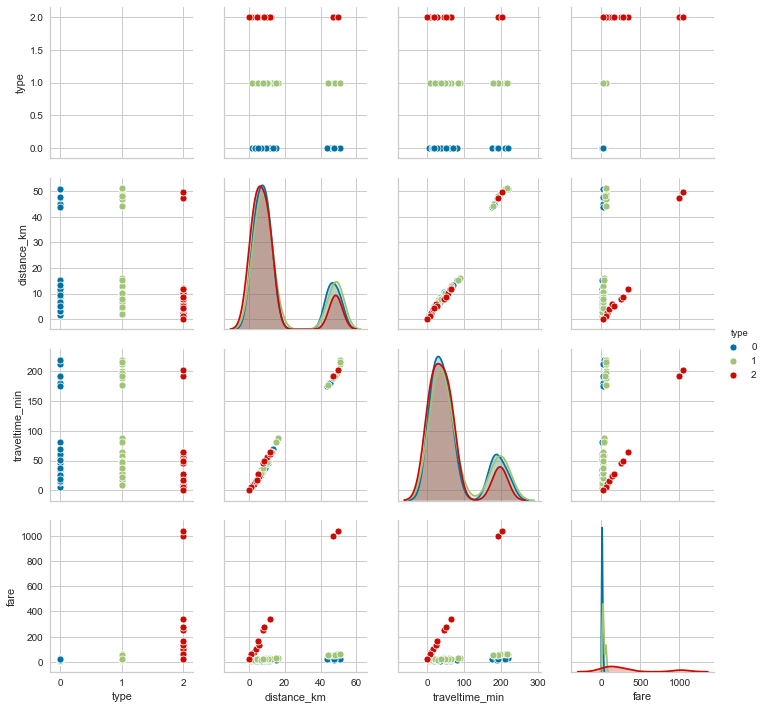

In [2854]:
# according to this plot, we decide to build three models for different uber type
my_ms_price_vis = my_ms_price.copy()[['type','distance_km','traveltime_min','fare']]
sns.pairplot(my_ms_price_vis, hue = 'type',diag_kind = 'kde')

### 6.1 Building model using missing data (non-na part) and cleaned dirty data (non-imputation part) 

In [2855]:
dirty_data_cleaned_4price = clean_d[['id', 'type', 'orir', 'desr','orilat', 'orilong', 'deslat','deslong', 'distance_m', 'oridate',
       'oritime', 'traveltime_s', 'destime', 'fare']].copy()

In [2856]:
# date out of range imputation cannot be used in modelling
dirty_data_cleaned_4price = dirty_data_cleaned_4price[~dirty_data_cleaned_4price.index.isin(err_date_outrange)]
dirty_data_cleaned_4price = dirty_data_cleaned_4price[~dirty_data_cleaned_4price.index.isin(err_date_mdreverse)]

In [2857]:
dirty_data_cleaned_4price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 298
Data columns (total 14 columns):
id              283 non-null object
type            283 non-null int64
orir            283 non-null int64
desr            283 non-null int64
orilat          283 non-null float64
orilong         283 non-null float64
deslat          283 non-null float64
deslong         283 non-null float64
distance_m      283 non-null float64
oridate         283 non-null object
oritime         283 non-null object
traveltime_s    283 non-null float64
destime         283 non-null object
fare            283 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 33.2+ KB


In [2858]:
cleaned_data_p = df_pre_processing(dirty_data_cleaned_4price)
cleaned_data_p['index'] = 999
my_ms_price['index'] = 9999

In [2859]:
# Combine clean data and missing value
fare_model_building = pd.concat([cleaned_data_p,my_ms_price])
fare_model_data = fare_model_building.copy().dropna()

In [2860]:
fare_model_building.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 94
Data columns (total 19 columns):
id                    378 non-null object
type                  378 non-null int64
orir                  378 non-null int64
desr                  378 non-null int64
orilat                378 non-null float64
orilong               378 non-null float64
deslat                378 non-null float64
deslong               378 non-null float64
distance_km           378 non-null float64
oridate               378 non-null object
oritime               378 non-null object
traveltime_min        378 non-null float64
destime               378 non-null object
fare                  360 non-null float64
oridate_wdaynum       378 non-null datetime64[ns]
oriweekday_weekend    378 non-null object
wkd_mark              378 non-null int64
ori_hour_id           378 non-null int64
index                 378 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(6), object(5)
memory usage: 59.1+ KB


In [2861]:
# use four features to construct the model
def lineaRegression(data):
    X = data.loc[:,('ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark')]
    Y = data.loc[:,'fare']

    lm = LinearRegression()
    lm.fit(X,Y)
    print ('r-squared for this model = ',round(lm.score(X,Y),4))
    feature_cols = ['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']
    B=list(zip(feature_cols,lm.coef_))
    df_coe = pd.DataFrame(B, columns = ['Variable', 'coef']) 
    print(f'coefficient:{df_coe}\n')  
    print (f'intercept:{lm.intercept_}')

    visualizer = ResidualsPlot(lm)
    visualizer.fit(X, Y)
    visualizer.score(X, Y)
    visualizer.poof() 
    return lm

### 6.2 Uber Type 0 model building and outlier detection

r-squared for this model =  0.9615
coefficient:         Variable                 coef
0     ori_hour_id                 3.62
1     distance_km                 0.05
2  traveltime_min                 0.09
3        wkd_mark                 5.00

intercept:3.2839020792488274


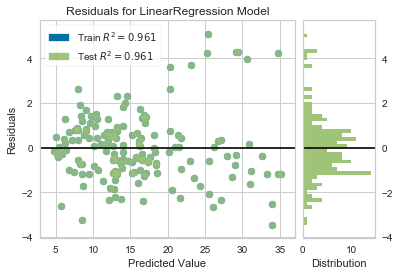

In [2862]:
fare_model_type0 = fare_model_data[fare_model_data.type==0].copy()
lm_type0 = lineaRegression(fare_model_type0)

> reshape the outlier data and do the pre-processing

In [2863]:
out_raw = pd.read_csv('dataset/outliers.csv')

In [2864]:
out_raw1 = out_raw.copy()

In [2865]:
def df_pre_processing_out(df):
    df.columns = ['index','id', 'type', 'orir', 'desr','orilat', 'orilong', 'deslat',
       'deslong', 'distance_m', 'oridate', 'oritime', 'traveltime_s', 'destime', 'fare']
    df['oridate_wdaynum'] = df['oridate'].apply(Convert_date)
    df['oriweekday_weekend']=df['oridate_wdaynum'].apply\
                    (lambda x: 'weekend' if x.weekday() in [5,6] else 'weekday' )
    df['wkd_mark'] = df.oriweekday_weekend.apply(lambda x: 1 if x =='weekend' else 0)
    df['ori_hour_id']= df['oritime'].apply(ori_hour_id) 
    df.distance_m = df.distance_m.apply(lambda x: x/1000)
    df.traveltime_s = df.traveltime_s.apply(lambda x: x/60)
    df.columns = ['index','id', 'type', 'orir', 'desr', 'orilat', 'orilong', 'deslat', 'deslong',
       'distance_km', 'oridate', 'oritime', 'traveltime_min', 'destime', 'fare',
       'oridate_wdaynum', 'oriweekday_weekend', 'wkd_mark', 'ori_hour_id']
    return df

In [2866]:
out_data = df_pre_processing_out(out_raw1)

In [2867]:
out_data_type0 = out_data[out_data.type ==0]

> use 3 zigma rule to detect outlier

In [2868]:
# predict on clean dataset
fare_model_type0['predict_fare'] = lm_type0.predict(fare_model_type0[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
fare_model_type0['residual'] = fare_model_type0.apply(lambda row: row['predict_fare']- row['fare'], axis=1)
residl_cleanmodel_type0 = fare_model_type0['residual']
# calculate the mean of residual
residl_cleanmodel_type0_mean = np.mean(residl_cleanmodel_type0)
print(f'Mean of residual in type 0: {residl_cleanmodel_type0_mean}')

Mean of residual in type 0: 1.554312234475219e-16


In [2869]:
# calculate the std and generate the upper and lower 3 zigma bound
residl_cleanmodel_type0_std = np.std(residl_cleanmodel_type0)
upper_type0 = residl_cleanmodel_type0_mean + 3 * residl_cleanmodel_type0_std
lower_type0 = residl_cleanmodel_type0_mean - 3 * residl_cleanmodel_type0_std
print(f'Type 0 Residual 3 sigma, Lower:{round(lower_type0,3)} Upper: {round(upper_type0,3)}')

Type 0 Residual 3 sigma, Lower:-4.505 Upper: 4.505


> Predict on outlier data and apply 3 sigma rule for detecting outliers

In [2870]:
out_data_type0['predict_fare'] = lm_type0.predict(out_data_type0[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
out_data_type0['residual'] = out_data_type0.apply(lambda row: row['predict_fare']- row['fare'], axis=1)
outlier_type0 = out_data_type0.query(' residual <@lower_type0 | residual >@upper_type0')
outlier_type0[['index','ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark','fare','predict_fare','residual']]

,index,ori_hour_id,distance_km,traveltime_min,wkd_mark,fare,predict_fare,residual
31,31,1,50.80,220.08,0,14.71,29.76,15.04
39,39,1,15.15,81.96,0,7.34,15.24,7.90
88,88,2,46.95,188.60,1,16.75,35.26,18.52
98,98,1,47.03,190.22,0,12.24,26.80,14.56


In [2871]:
to_delete_type0 = outlier_type0['index']
outlier_first_column = []
outlier_first_column.extend(to_delete_type0)

In [2872]:
outlier_first_column

[31, 39, 88, 98]

### 6.3 Uber Type 1 model building and outlier detection

r-squared for this model =  0.9883
coefficient:         Variable                 coef
0     ori_hour_id                 4.53
1     distance_km                 0.01
2  traveltime_min                 0.25
3        wkd_mark                 4.02

intercept:5.675608589540264


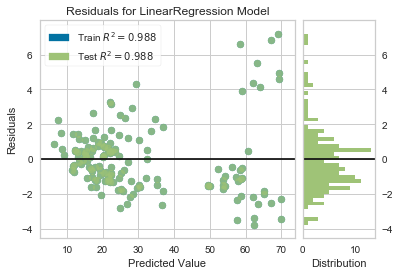

In [2873]:
fare_model_type1 = fare_model_data[fare_model_data.type==1].copy()
lm_type1 = lineaRegression(fare_model_type1)

In [2874]:
# calculate the mean, std and bound
fare_model_type1['predict_fare'] = lm_type1.predict(fare_model_type1[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
fare_model_type1['residual'] = fare_model_type1.apply(lambda row: row['predict_fare']- row['fare'], axis=1)
residl_cleanmodel_type1 = fare_model_type1['residual']
residl_cleanmodel_type1_mean = np.mean(residl_cleanmodel_type1)
print(f'Mean of residual in type 1: {residl_cleanmodel_type1_mean}')
residl_cleanmodel_type1_std = np.std(residl_cleanmodel_type1)
upper_type1 = residl_cleanmodel_type1_mean + 3 * residl_cleanmodel_type1_std
lower_type1 = residl_cleanmodel_type1_mean - 3 * residl_cleanmodel_type1_std
print(f'Type 1 Residual 3 sigma, Lower:{round(lower_type1,3)} Upper: {round(upper_type1,3)}')

Mean of residual in type 1: 2.3366841645801954e-15
Type 1 Residual 3 sigma, Lower:-5.97 Upper: 5.97


In [2875]:
out_data_type1 = out_data[out_data.type ==1]
out_data_type1['predict_fare'] = lm_type1.predict(out_data_type1[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
out_data_type1['residual'] = out_data_type1.apply(lambda row: row['predict_fare']- row['fare'], axis=1)
outlier_type1 = out_data_type1.query(' residual <@lower_type1 | residual >@upper_type1')
outlier_type1[['index','type','ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark','fare','predict_fare','residual']]

,index,type,ori_hour_id,distance_km,traveltime_min,wkd_mark,fare,predict_fare,residual
3,3,1,1,2.19,9.78,0,5.66,12.66,7.00
8,8,1,2,8.36,40.64,0,11.76,24.92,13.17
15,15,1,2,50.80,219.56,0,38.58,69.82,31.24
16,16,1,0,4.89,25.14,0,5.42,11.98,6.55
25,25,1,2,10.83,58.83,1,15.93,33.49,17.56
52,52,1,1,50.80,220.08,0,73.36,65.43,-7.93
65,65,1,1,7.61,34.03,0,8.70,18.74,10.04
68,68,1,0,48.75,198.61,1,33.22,59.54,26.33
82,82,1,1,7.03,34.29,0,8.71,18.80,10.10
101,101,1,2,12.69,67.98,0,15.32,31.77,16.45


In [2876]:
to_delete_type1 = outlier_type1['index']
outlier_first_column.extend(to_delete_type1)

### 6.4 Uber Type 2 model building and outlier detection

r-squared for this model =  0.9996
coefficient:         Variable                 coef
0     ori_hour_id                 8.44
1     distance_km                 0.17
2  traveltime_min                 5.16
3        wkd_mark                 5.25

intercept:13.766082308220177


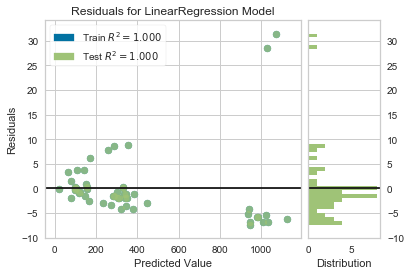

In [2877]:
fare_model_type2 = fare_model_data[fare_model_data.type==2].copy()
lm_type2 = lineaRegression(fare_model_type2)

In [2878]:
# calculate the mean, std and bound using the clean data
fare_model_type2['predict_fare'] = lm_type2.predict(fare_model_type2[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
fare_model_type2['residual'] = fare_model_type2.apply(lambda row: row['predict_fare']- row['fare'], axis=1)
residl_cleanmodel_type2= fare_model_type2['residual']
residl_cleanmodel_type2_mean = np.mean(residl_cleanmodel_type2)
print(f'Mean of residual in type 2: {residl_cleanmodel_type2_mean}')
residl_cleanmodel_type2_std = np.std(residl_cleanmodel_type2)
upper_type2 = residl_cleanmodel_type2_mean + 3 * residl_cleanmodel_type2_std
lower_type2 = residl_cleanmodel_type2_mean - 3 * residl_cleanmodel_type2_std
print(f'Type 2 Residual 3 sigma, Lower:{round(lower_type2,3)} Upper: {round(upper_type2,3)}')

Mean of residual in type 2: -9.209191143871103e-14
Type 2 Residual 3 sigma, Lower:-21.334 Upper: 21.334


In [2879]:
# detect the outliers using clean model and the 3 sigma from clean data
out_data_type2 = out_data[out_data.type ==2]
out_data_type2['predict_fare'] = lm_type2.predict(out_data_type2[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
out_data_type2['residual'] = out_data_type2.apply(lambda row: row['predict_fare']- row['fare'], axis=1)
outlier_type2 = out_data_type2.query(' residual <@lower_type2 | residual >@upper_type2')
outlier_type2[['index','ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark','fare','predict_fare','residual']]

,index,ori_hour_id,distance_km,traveltime_min,wkd_mark,fare,predict_fare,residual
36,36,0,47.03,189.26,0,684.45,998.49,314.04
41,41,1,11.71,61.96,0,239.52,343.93,104.41
45,45,1,6.36,27.48,0,117.00,165.12,48.12
51,51,2,5.63,21.83,0,51.58,144.25,92.67
64,64,0,9.64,53.67,0,202.07,292.38,90.31
89,89,2,51.03,211.35,0,779.41,"1,130.04",350.63
96,96,1,49.78,201.16,1,742.74,"1,074.07",331.33
100,100,2,4.57,19.24,0,94.93,130.70,35.77
106,106,2,9.57,45.90,0,190.44,269.14,78.70
109,109,2,15.15,81.96,0,321.06,456.16,135.10


In [2880]:
to_delete_type2 = outlier_type2['index']
outlier_first_column.extend(to_delete_type2)

In [2881]:
len(outlier_first_column)

27

> export the outliers output

In [2882]:
out_copy = out_raw.copy()
out_output = out_copy[~out_copy['Unnamed: 0'].isin(outlier_first_column)]

In [2883]:
out_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 15 columns):
Unnamed: 0               121 non-null int64
Unnamed: 0.1             121 non-null object
Uber Type                121 non-null int64
Origin Region            121 non-null int64
Destination Region       121 non-null int64
Origin Latitude          121 non-null float64
Origin Longitude         121 non-null float64
Destination Latitude     121 non-null float64
Destination Longitude    121 non-null float64
Journey Distance(m)      121 non-null float64
Departure Date           121 non-null object
Departure Time           121 non-null object
Travel Time(s)           121 non-null float64
Arrival Time             121 non-null object
Fare$                    121 non-null float64
dtypes: float64(7), int64(4), object(4)
memory usage: 14.3+ KB


In [2884]:
out_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 120
Data columns (total 15 columns):
Unnamed: 0               94 non-null int64
Unnamed: 0.1             94 non-null object
Uber Type                94 non-null int64
Origin Region            94 non-null int64
Destination Region       94 non-null int64
Origin Latitude          94 non-null float64
Origin Longitude         94 non-null float64
Destination Latitude     94 non-null float64
Destination Longitude    94 non-null float64
Journey Distance(m)      94 non-null float64
Departure Date           94 non-null object
Departure Time           94 non-null object
Travel Time(s)           94 non-null float64
Arrival Time             94 non-null object
Fare$                    94 non-null float64
dtypes: float64(7), int64(4), object(4)
memory usage: 11.8+ KB


In [2885]:
out_output.to_csv('outliers_solution.csv',index=False)

## 7. Use the regression model for imputation

In [2886]:
ms_raw = pd.read_csv('dataset/missing_value.csv')

In [2887]:
ms_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 14 columns):
Unnamed: 0               95 non-null object
Uber Type                75 non-null float64
Origin Region            95 non-null int64
Destination Region       95 non-null int64
Origin Latitude          95 non-null float64
Origin Longitude         95 non-null float64
Destination Latitude     95 non-null float64
Destination Longitude    95 non-null float64
Journey Distance(m)      95 non-null float64
Departure Date           95 non-null object
Departure Time           95 non-null object
Travel Time(s)           95 non-null float64
Arrival Time             95 non-null object
Fare$                    77 non-null float64
dtypes: float64(8), int64(2), object(4)
memory usage: 10.5+ KB


In [2888]:
ms_raw.columns

Index(['Unnamed: 0', 'Uber Type', 'Origin Region', 'Destination Region',
       'Origin Latitude', 'Origin Longitude', 'Destination Latitude',
       'Destination Longitude', 'Journey Distance(m)', 'Departure Date',
       'Departure Time', 'Travel Time(s)', 'Arrival Time', 'Fare$'],
      dtype='object')

In [2889]:
def uber_type_correct_float(id):
    if id.startswith('ID3'):
        return 1.0
    elif id.startswith('ID5'):
        return 2.0
    elif id.startswith('ID1'):
        return 0.0

> imputation on the uber type

In [2890]:
ms_raw['Uber Type'] = ms_raw['Unnamed: 0'].apply(uber_type_correct_float)

In [2891]:
ms_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 14 columns):
Unnamed: 0               95 non-null object
Uber Type                95 non-null float64
Origin Region            95 non-null int64
Destination Region       95 non-null int64
Origin Latitude          95 non-null float64
Origin Longitude         95 non-null float64
Destination Latitude     95 non-null float64
Destination Longitude    95 non-null float64
Journey Distance(m)      95 non-null float64
Departure Date           95 non-null object
Departure Time           95 non-null object
Travel Time(s)           95 non-null float64
Arrival Time             95 non-null object
Fare$                    77 non-null float64
dtypes: float64(8), int64(2), object(4)
memory usage: 10.5+ KB


In [2892]:
ms_raw1 = ms_raw.copy()

In [2893]:
ms_fare = df_pre_processing(ms_raw1)

> predict fare for type 0

In [2894]:
ms_na0 = ms_fare[(ms_fare.type==0) & ms_fare.fare.isnull()]
ms_na0_pdt = lm_type0.predict(ms_na0[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
ms_na0_index = ms_na0[(ms_na0.type==0) & ms_na0.fare.isnull()].index
ms_fare.iloc[ms_na0_index,13] = ms_na0_pdt
ms_fare[(ms_fare.type==0) & ms_fare.fare.isnull()]

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_km,oridate,oritime,traveltime_min,destime,fare,oridate_wdaynum,oriweekday_weekend,wkd_mark,ori_hour_id


In [2895]:
ms_na0_pdt

array([13.53479298, 22.19155515, 14.4789999 , 29.70673148,  8.51059574,
       14.56385787,  9.95042707,  5.31005578, 17.65807913])

> predict fare for type 1

In [2896]:
ms_na1 = ms_fare[(ms_fare.type==1) & ms_fare.fare.isnull()]
ms_na1_pdt = lm_type1.predict(ms_na1[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
ms_na1_index = ms_na1[(ms_na1.type==1) & ms_na1.fare.isnull()].index
ms_fare.iloc[ms_na1_index,13] = ms_na1_pdt
ms_fare[(ms_fare.type==1) & ms_fare.fare.isnull()]

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_km,oridate,oritime,traveltime_min,destime,fare,oridate_wdaynum,oriweekday_weekend,wkd_mark,ori_hour_id


In [2897]:
ms_na1_pdt

array([14.41098618, 26.50881793,  7.80802401, 17.48771211, 20.22582501])

> predict fare for type 2

In [2898]:
ms_na2 = ms_fare[(ms_fare.type==2) & ms_fare.fare.isnull()]
ms_na2_pdt = lm_type2.predict(ms_na2[['ori_hour_id', 'distance_km', 'traveltime_min','wkd_mark']])
ms_na2_index = ms_na2[(ms_na2.type==2) & ms_na2.fare.isnull()].index
ms_fare.iloc[ms_na2_index,13] = ms_na2_pdt
ms_fare[(ms_fare.type==2) & ms_fare.fare.isnull()]

,id,type,orir,desr,orilat,orilong,deslat,deslong,distance_km,oridate,oritime,traveltime_min,destime,fare,oridate_wdaynum,oriweekday_weekend,wkd_mark,ori_hour_id


In [2899]:
ms_na2_pdt

array([325.23094666, 353.53083268, 350.94793757, 121.286684  ])

> export the output for missing values

In [2900]:
ms_raw.iloc[:,-1] = ms_fare['fare'].values

In [2901]:
ms_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 14 columns):
Unnamed: 0               95 non-null object
Uber Type                95 non-null float64
Origin Region            95 non-null int64
Destination Region       95 non-null int64
Origin Latitude          95 non-null float64
Origin Longitude         95 non-null float64
Destination Latitude     95 non-null float64
Destination Longitude    95 non-null float64
Journey Distance(m)      95 non-null float64
Departure Date           95 non-null object
Departure Time           95 non-null object
Travel Time(s)           95 non-null float64
Arrival Time             95 non-null object
Fare$                    95 non-null float64
dtypes: float64(8), int64(2), object(4)
memory usage: 10.5+ KB


In [1]:
ms_raw.to_csv('missing_value_solution.csv',index=False)

NameError: name 'ms_raw' is not defined

## 8. Conclusion
> What we have done in this task:
1. We create a **logic map** to handle the data cleasing problems, break them into component parts.
2. First, we use the clean data(missing dataset) to EDA.
3. Then, we fix all the errors in the dirty data set step by step.
4. After we combine all available clean (no imputation) data we have, we build our model on top of that.
5. 3 sigma rule is applied in the next stage for detecting outliers.
6. Finally, we implement the imputation for the NAs in the missing value dataset.